# Week 2 – Classification
## Logistic Regression: From Intuition to Gradient Descent

In this notebook we will:

1. Motivate **classification** and compare it with linear regression.
2. Introduce the **logistic regression model**:
   $$
   f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b)
   $$
3. Understand **decision boundaries**:
   - Linear boundaries in the original feature space.
   - Nonlinear boundaries via **feature transformations** (polynomial features).
4. Define the **logistic loss** and the **cost function**.
5. Derive and implement the **gradients** of the cost function.
6. Implement **gradient descent** and visualize **cost vs iterations**.

Notation (we keep it explicit and consistent):

- Vectors: $\vec{w}, \vec{x}$ (conceptual). In code they are NumPy arrays.
- Hypothesis (model): $f_{\vec{w}, b}(\vec{x})$.
- For sample $i$: $f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = f_{\vec{w}, b}(\vec{x}^{(i)})$.


In [2]:
%pip install numpy matplotlib 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

Matplotlib is building the font cache; this may take a moment.


## Step 1 Load the Data set and binarice the dataset


### We have to Binarize the last column of the dataset, after that we have to sumarize the stats that we have, handle missing/outliers and finally we are goning to represent our by plots of the classes distribution

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
DATA PREPARATION
Target column 'Heart Disease' binarized: [1 0]
   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

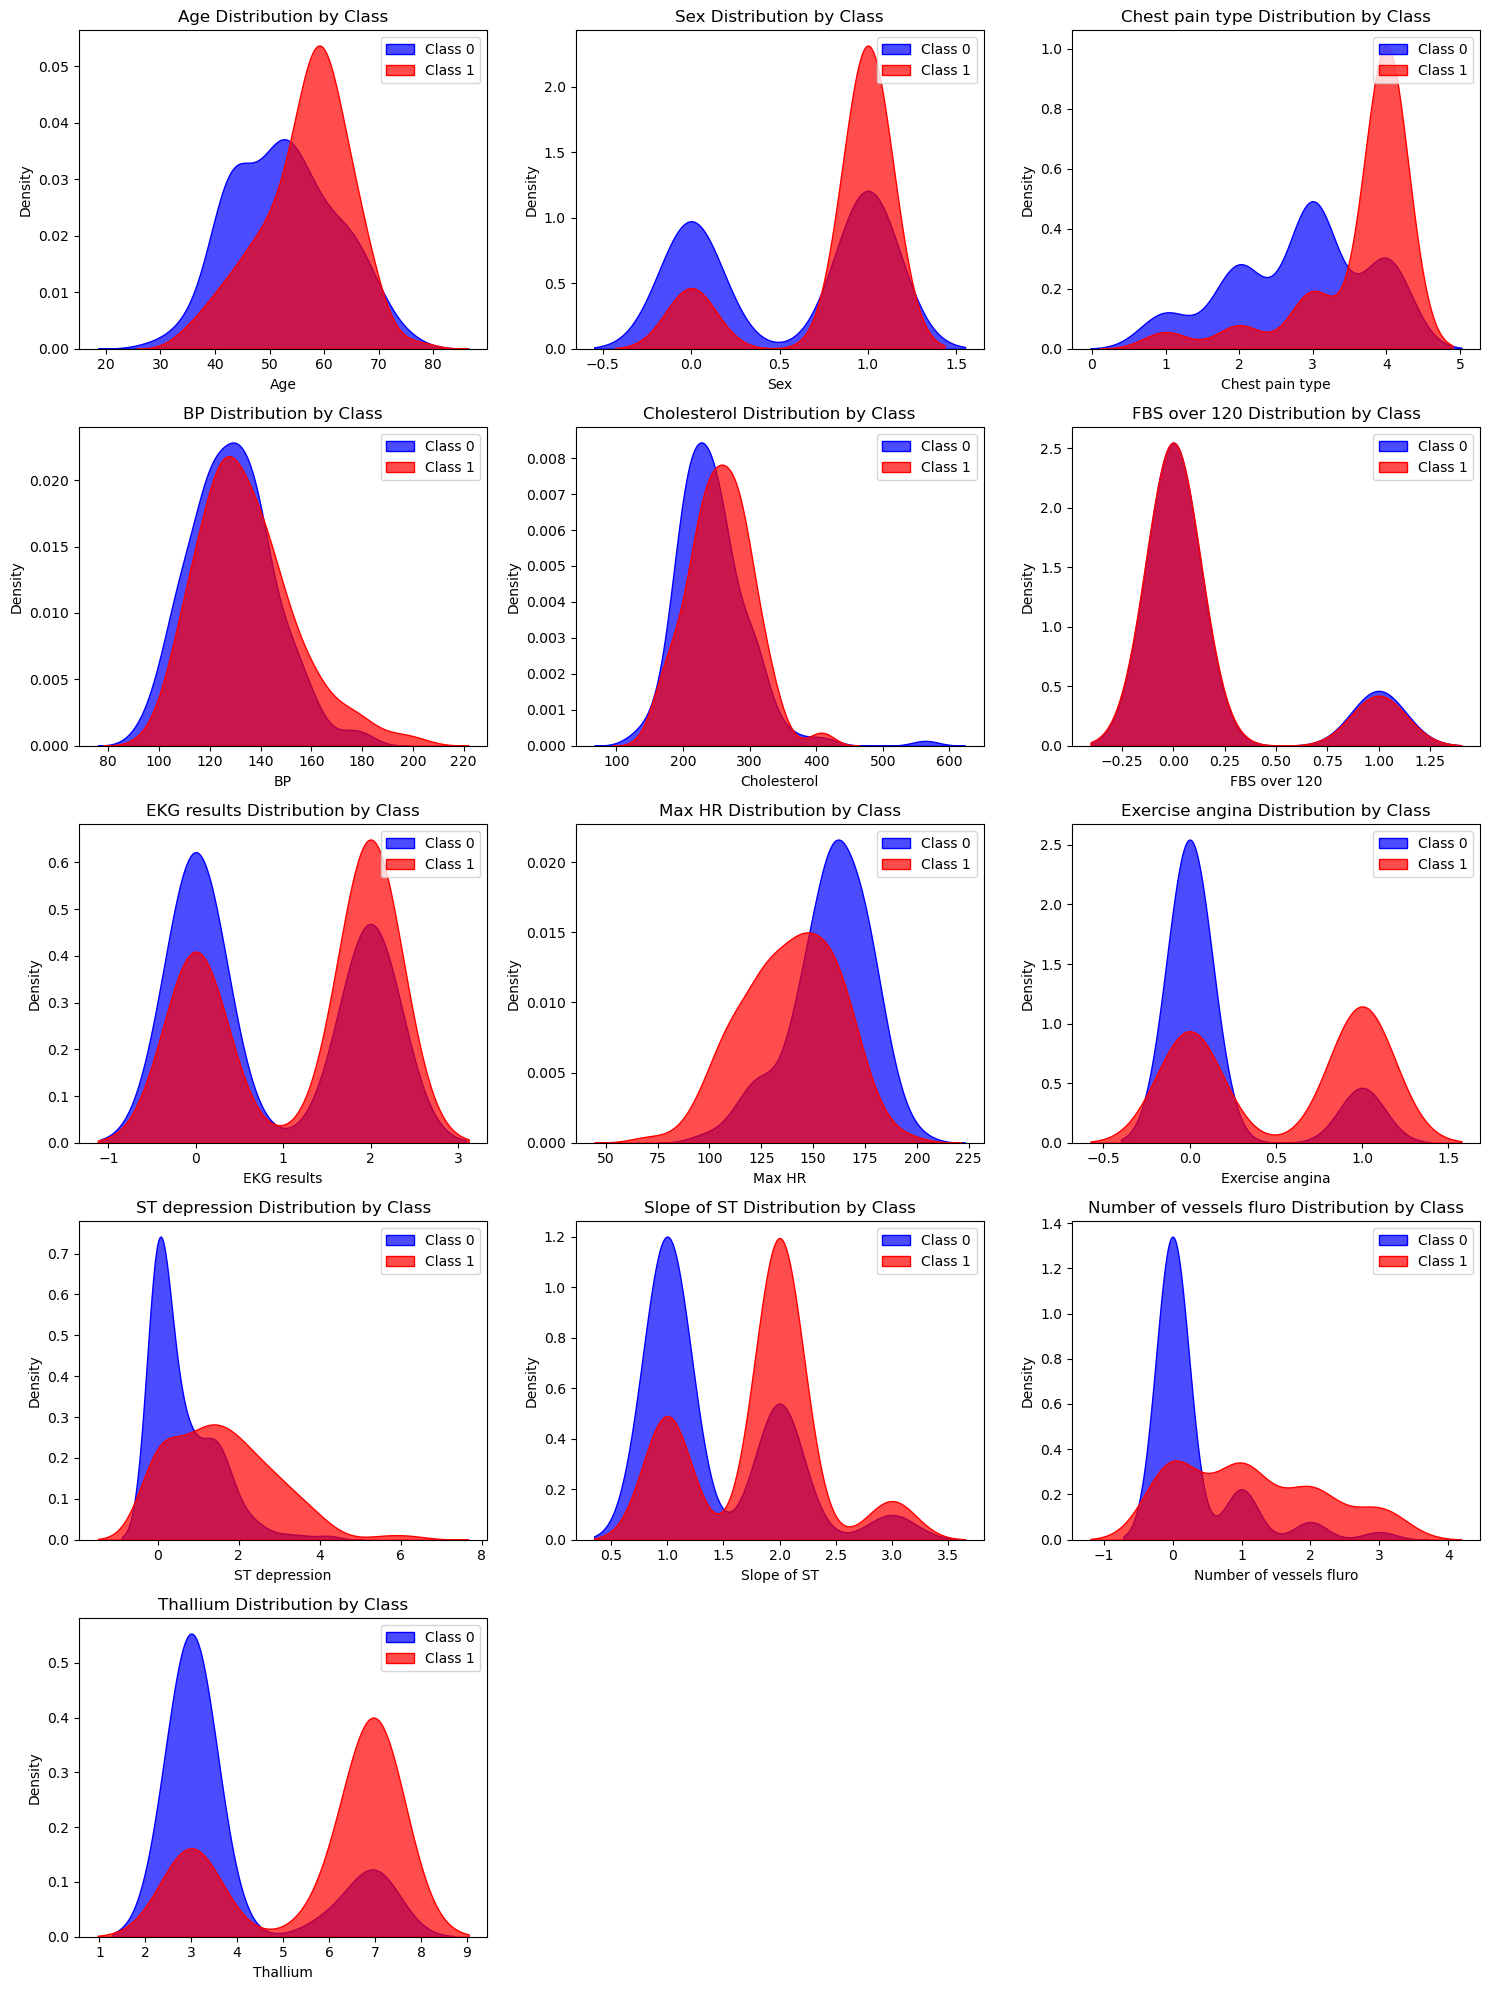

In [1]:
%pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Heart_Disease_Prediction.csv')
target_col = df.columns[-1]

print("="*60)
print("DATA PREPARATION")
print("="*60)


df[target_col] = df[target_col].map({
    'presence': 1, 'Presence': 1, 'PRESENCE': 1,
    'absence': 0, 'Absence': 0, 'ABSENCE': 0
})
print(f"Target column '{target_col}' binarized: {df[target_col].unique()}")
print(df.head())
print(f"\nDataset shape: {df.shape[0]} rows, {df.shape[1]} columns")


print("\n" + "="*60)
print("SUMMARIZE STATS")
print("="*60)


print("\n2. DATA TYPES:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   {dtype}: {count} columns")

print("\n3. DESCRIPTIVE STATISTICS (all columns):")


numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    print("\n   Numerical columns statistics:")
    numeric_stats = df[numeric_cols].describe().T
    numeric_stats['range'] = numeric_stats['max'] - numeric_stats['min']
    numeric_stats['cv'] = (numeric_stats['std'] / numeric_stats['mean'] * 100).round(2)  # Coeficiente de variación
    print(numeric_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'cv']].round(2))


categorical_cols = df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print("\n   Categorical columns summary:")
    for col in categorical_cols:
        unique_vals = df[col].nunique()
        top_value = df[col].value_counts().index[0] if len(df[col].value_counts()) > 0 else 'N/A'
        top_freq = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0
        print(f"   {col}: {unique_vals} unique values, most common: '{top_value}' ({top_freq} times)")


print("\n4. CORRELATIONS (numerical columns):")
if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()
 
    if target_col in numeric_cols:
        target_corr = corr_matrix[target_col].sort_values(ascending=False)
        print("\n   Correlation with target:")
        for col, corr in target_corr.items():
            if col != target_col:
                print(f"   {col}: {corr:.3f}")
    

    print("\n   Top feature correlations (absolute):")
    corr_series = corr_matrix.unstack()
    corr_series = corr_series[corr_series.index.get_level_values(0) != corr_series.index.get_level_values(1)]
    corr_series = corr_series.abs().sort_values(ascending=False)
    top_corrs = corr_series.head(5)
    for idx, value in top_corrs.items():
        print(f"   {idx[0]} - {idx[1]}: {df.corr().loc[idx[0], idx[1]]:.3f}")


print("\n5. TARGET DISTRIBUTION:")
class_counts = df[target_col].value_counts()
class_percent = df[target_col].value_counts(normalize=True) * 100
for cls, (count, percent) in enumerate(zip(class_counts, class_percent)):
    print(f"   Class {cls}: {count} samples ({percent:.1f}%)")
print(f"   Balance ratio: {min(class_counts)/max(class_counts):.3f}")


print("MISSING VALUES")
print("="*60)
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values found")
else:
    print(f"Found {missing.sum()} missing values")
    for col in df.columns[df.isnull().any()]:
        missing_pct = (df[col].isnull().sum() / len(df)) * 100
        print(f"   {col}: {df[col].isnull().sum()} ({missing_pct:.1f}%)")
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
            print(f"     → Imputed with median: {df[col].median():.2f}")
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
            print(f"     → Imputed with mode: '{df[col].mode()[0]}'")


print("CLASS DISTRIBUTION")

print(f"Class 0: {class_counts[0]} samples ({class_counts[0]/len(df)*100:.1f}%)")
print(f"Class 1: {class_counts[1]} samples ({class_counts[1]/len(df)*100:.1f}%)")


print("VISUALIZING ALL COLUMNS")


n_cols = len(df.columns) - 1
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(df.columns):
    if col == target_col:
        continue
    
    ax = axes[idx]
    
    if df[col].dtype in ['int64', 'float64']:
        for class_val, color in zip([0, 1], ['blue', 'red']):
            subset = df[df[target_col] == class_val][col].dropna()
            if len(subset) > 1:
                sns.kdeplot(subset, ax=ax, label=f'Class {class_val}', 
                          color=color, alpha=0.7, fill=True)
        ax.set_title(f'{col} Distribution by Class')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.legend()
    else:
        cross_tab = pd.crosstab(df[col], df[target_col])
        cross_tab.plot(kind='bar', stacked=True, ax=ax, 
                      color=['blue', 'red'], alpha=0.7)
        ax.set_title(f'{col} by Class')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.legend(['Class 0', 'Class 1'])
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## For the 70/30 slit of the rows that we need we are going to divide it like this:

In [8]:
import numpy as np

selected_cols = ["Age", "Sex", "Cholesterol", "BP", "Max HR", "ST depression", "Number of vessels fluro", "Heart Disease"]

data_subset = df[selected_cols].copy()

np.random.seed(42)
shuffled_indices = np.random.permutation(len(data_subset))
data_shuffled = data_subset.iloc[shuffled_indices].reset_index(drop=True)

split_idx = int(0.7 * len(data_shuffled))

train_data = data_shuffled.iloc[:split_idx]
test_data = data_shuffled.iloc[split_idx:]

X_train = train_data[selected_cols[:-1]].to_numpy()
y_train = train_data[selected_cols[-1]].to_numpy()
X_test = test_data[selected_cols[:-1]].to_numpy()
y_test = test_data[selected_cols[-1]].to_numpy()

X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.float64)

train_means = np.mean(X_train, axis=0)
train_stds = np.std(X_train, axis=0) + 1e-10

X_train_norm = (X_train - train_means) / train_stds
X_test_norm = (X_test - train_means) / train_stds

X_train, y_train = X_train_norm, y_train
X_test, y_test = X_test_norm, y_test

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")

Training samples: 189
Testing samples: 81
Features: 7


## Step 2. Implement Basic Logistic Regression

### Sigmoid Function

The sigmoid function converts linear values into probabilities between 0 and 1.

σ(z) = 1 / (1 + e^(-z))

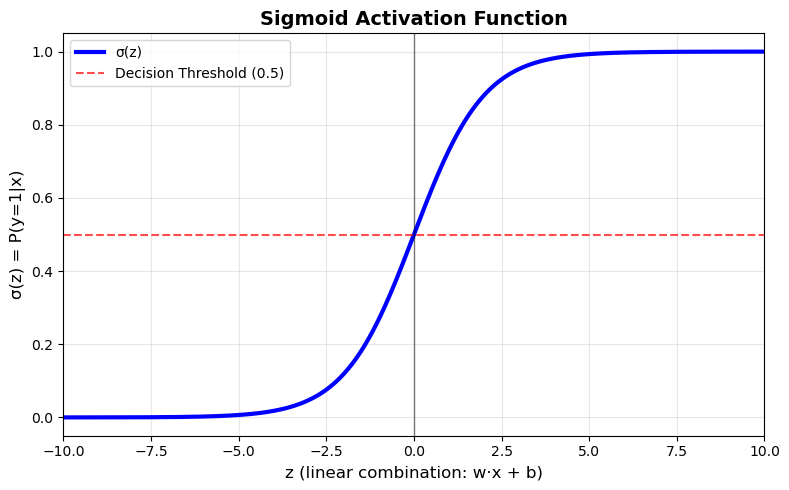

In [32]:
def sigmoid(z):
    z_clipped = np.clip(z, -20, 20)
    return 1 / (1 + np.exp(-z_clipped))

plt.figure(figsize=(8, 5))
z_values = np.linspace(-10, 10, 400)
sigma_values = sigmoid(z_values)

plt.plot(z_values, sigma_values, 'b-', linewidth=3, label='σ(z)')
plt.axhline(0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Decision Threshold (0.5)')
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3)
plt.xlabel('z (linear combination: w·x + b)', fontsize=12)
plt.ylabel('σ(z) = P(y=1|x)', fontsize=12)
plt.title('Sigmoid Activation Function', fontsize=14, fontweight='bold')
plt.legend()
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 10)
plt.tight_layout()
plt.show()

### Cost Binary Entropy

Measures error between predictions and actual values.

J(w,b) = -1/m Σ [yⁱ·log(h(xⁱ)) + (1-yⁱ)·log(1-h(xⁱ))]

In [12]:
def compute_cost(w, b, X, y):
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)
    
    eps = 1e-15
    f = np.clip(f, eps, 1 - eps)
    
    J = -(1 / m) * np.sum(
        y * np.log(f) + (1 - y) * np.log(1 - f)
    )
    return J

### Gradient Function
Calculates the direction of steepest descent to optimize parameters.

∂J/∂wⱼ = 1/m Σ (h(xⁱ)-yⁱ)·xⱼⁱ
∂J/∂b = 1/m Σ (h(xⁱ)-yⁱ)

Forma vectorizada:
∇wJ = 1/m Xᵀ(h(X)-y)

In [13]:
def compute_gradient(w, b, X, y):
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)
    error = f - y
    dj_dw = (1 / m) * (X.T @ error)
    dj_db = (1 / m) * np.sum(error)
    return dj_dw, dj_db

### Gradient Decent

Iterative algorithm to minimize the cost function.

Actualización de parámetros:
w := w - α·∇wJ
b := b - α·∂J/∂b

In [14]:
def gradient_descent(X, y, w_init, b_init, alpha, num_iters, print_every=50):
    w = w_init.copy()
    b = b_init
    J_history = []
    
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(w, b, X, y)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        J = compute_cost(w, b, X, y)
        J_history.append(J)
        
        if print_every > 0 and (i % print_every == 0 or i == num_iters - 1):
            print(f"Iteration {i:4d}: J(w,b) = {J:.4f}")
    
    return w, b, J_history

### Prediction function

Convert probabilities into binary classes.
decition rule:

ŷ = 1 si σ(w·x + b) ≥ 0.5
ŷ = 0 si σ(w·x + b) < 0.5

Interpretación clínica:

Probabilidad ≥50% → diagnóstico positivo

Probabilidad <50% → diagnóstico negativo

In [ ]:
def calculate_z(X, w, b):
    return X @ w + b

def predict(X, w, b, threshold=0.5):
    z = calculate_z(X, w, b)
    pred = sigmoid(z)
    return pred >= threshold

### Metrics Calculation

Model performance assessment.

Confusion matrix:

True Positive (TP): Diseased patients correctly identified

True Negative (TN): Healthy patients correctly identified

False Positive (FP): Healthy patients diagnosed as diseased

False Negative (FN): Diseased patients diagnosed as healthy

In [16]:
def calculateParameters(y_true, y_pred):
    TP = np.sum((y_true == 1.0) & (y_pred == 1.0))
    TN = np.sum((y_true == 0.0) & (y_pred == 0.0))
    FP = np.sum((y_true == 0.0) & (y_pred == 1.0))
    FN = np.sum((y_true == 1.0) & (y_pred == 0.0))
    return TP, TN, FP, FN

### Training Setup



In [17]:
m, n = X_train.shape

w0 = np.zeros(n)
b0 = 0.0
learning_rate = 0.01
max_iterations = 3000

w_trained, b_trained, J_hist = gradient_descent(X_train, y_train, w0, b0, learning_rate, max_iterations, 100)

print("\nTrained parameters:")
print(f"Intercept: {b_trained}")
print(f"Weights: {w_trained}")

Iteration    0: J(w,b) = 0.6914
Iteration  100: J(w,b) = 0.5752
Iteration  200: J(w,b) = 0.5197
Iteration  300: J(w,b) = 0.4885
Iteration  400: J(w,b) = 0.4689
Iteration  500: J(w,b) = 0.4555
Iteration  600: J(w,b) = 0.4460
Iteration  700: J(w,b) = 0.4388
Iteration  800: J(w,b) = 0.4333
Iteration  900: J(w,b) = 0.4289
Iteration 1000: J(w,b) = 0.4254
Iteration 1100: J(w,b) = 0.4225
Iteration 1200: J(w,b) = 0.4202
Iteration 1300: J(w,b) = 0.4182
Iteration 1400: J(w,b) = 0.4165
Iteration 1500: J(w,b) = 0.4151
Iteration 1600: J(w,b) = 0.4139
Iteration 1700: J(w,b) = 0.4128
Iteration 1800: J(w,b) = 0.4119
Iteration 1900: J(w,b) = 0.4111
Iteration 2000: J(w,b) = 0.4105
Iteration 2100: J(w,b) = 0.4099
Iteration 2200: J(w,b) = 0.4093
Iteration 2300: J(w,b) = 0.4089
Iteration 2400: J(w,b) = 0.4084
Iteration 2500: J(w,b) = 0.4081
Iteration 2600: J(w,b) = 0.4077
Iteration 2700: J(w,b) = 0.4074
Iteration 2800: J(w,b) = 0.4072
Iteration 2900: J(w,b) = 0.4070
Iteration 2999: J(w,b) = 0.4067

Trained

### Plot Cost


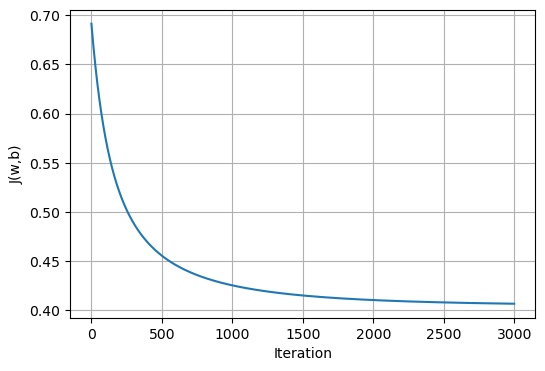

In [18]:
plt.figure()
plt.plot(J_hist)
plt.xlabel("Iteration")
plt.ylabel("J(w,b)")
plt.show()

### Calculate Metrics


In [19]:
Y_pred_train = predict(X_train, w_trained, b_trained)
Y_pred_test = predict(X_test, w_trained, b_trained)

TP_train, TN_train, FP_train, FN_train = calculateParameters(y_train, Y_pred_train)
TP_test, TN_test, FP_test, FN_test = calculateParameters(y_test, Y_pred_test)

accuracy_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train)
accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test)

precision_train = TP_train / (TP_train + FP_train) if (TP_train + FP_train) > 0 else 0
precision_test = TP_test / (TP_test + FP_test) if (TP_test + FP_test) > 0 else 0

recall_train = TP_train / (TP_train + FN_train) if (TP_train + FN_train) > 0 else 0
recall_test = TP_test / (TP_test + FN_test) if (TP_test + FN_test) > 0 else 0

f1_score_train = 2 * ((precision_train * recall_train) / (precision_train + recall_train)) if (precision_train + recall_train) > 0 else 0
f1_score_test = 2 * ((precision_test * recall_test) / (precision_test + recall_test)) if (precision_test + recall_test) > 0 else 0


print("MODEL PERFORMANCE METRICS")

print("\nTRAIN SET:")
print(f"Accuracy:  {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall:    {recall_train:.4f}")
print(f"F1-Score:  {f1_score_train:.4f}")

print("\nTEST SET:")
print(f"Accuracy:  {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall:    {recall_test:.4f}")
print(f"F1-Score:  {f1_score_test:.4f}")

print("CONFUSION MATRIX")

print("\nTRAIN SET:")
print(f"True Positives:  {TP_train}")
print(f"True Negatives:  {TN_train}")
print(f"False Positives: {FP_train}")
print(f"False Negatives: {FN_train}")

print("\nTEST SET:")
print(f"True Positives:  {TP_test}")
print(f"True Negatives:  {TN_test}")
print(f"False Positives: {FP_test}")
print(f"False Negatives: {FN_test}")

MODEL PERFORMANCE METRICS

TRAIN SET:
Accuracy:  0.8201
Precision: 0.8108
Recall:    0.7500
F1-Score:  0.7792

TEST SET:
Accuracy:  0.8025
Precision: 0.8529
Recall:    0.7250
F1-Score:  0.7838
CONFUSION MATRIX

TRAIN SET:
True Positives:  60
True Negatives:  95
False Positives: 14
False Negatives: 20

TEST SET:
True Positives:  29
True Negatives:  36
False Positives: 5
False Negatives: 11


## Step 3

###  Plot Boundary Function


For two features x₁ and x₂


In [20]:
def plot_boundary_and_scatter(X, y, w, b, title, feature_names):
    plt.figure()
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c="tab:blue", label="No disease", alpha=0.7)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c="tab:red", label="Disease", alpha=0.7)
    x1_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
    if abs(w[1]) < 1e-8:
        x1_line = -b / (w[0] + 1e-8)
        plt.axvline(x=x1_line, color="k", linestyle="--", label="Decision boundary")
    else:
        x2_vals = -(w[0] * x1_vals + b) / w[1]
        plt.plot(x1_vals, x2_vals, "k--", label="Decision boundary")
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.legend()
    plt.show()

### Age-Cholesterol

Iteration    0: J(w,b) = 0.6928
Iteration   50: J(w,b) = 0.6774
Iteration  100: J(w,b) = 0.6652
Iteration  150: J(w,b) = 0.6555
Iteration  200: J(w,b) = 0.6478
Iteration  250: J(w,b) = 0.6416
Iteration  300: J(w,b) = 0.6366
Iteration  350: J(w,b) = 0.6325
Iteration  400: J(w,b) = 0.6292
Iteration  450: J(w,b) = 0.6265
Iteration  500: J(w,b) = 0.6242
Iteration  550: J(w,b) = 0.6223
Iteration  600: J(w,b) = 0.6208
Iteration  650: J(w,b) = 0.6195
Iteration  700: J(w,b) = 0.6184
Iteration  750: J(w,b) = 0.6175
Iteration  800: J(w,b) = 0.6167
Iteration  850: J(w,b) = 0.6160
Iteration  900: J(w,b) = 0.6155
Iteration  950: J(w,b) = 0.6150
Iteration 1000: J(w,b) = 0.6146
Iteration 1050: J(w,b) = 0.6143
Iteration 1100: J(w,b) = 0.6140
Iteration 1150: J(w,b) = 0.6137
Iteration 1200: J(w,b) = 0.6135
Iteration 1250: J(w,b) = 0.6133
Iteration 1300: J(w,b) = 0.6131
Iteration 1350: J(w,b) = 0.6130
Iteration 1400: J(w,b) = 0.6129
Iteration 1450: J(w,b) = 0.6128
Iteration 1500: J(w,b) = 0.6127
Iteratio

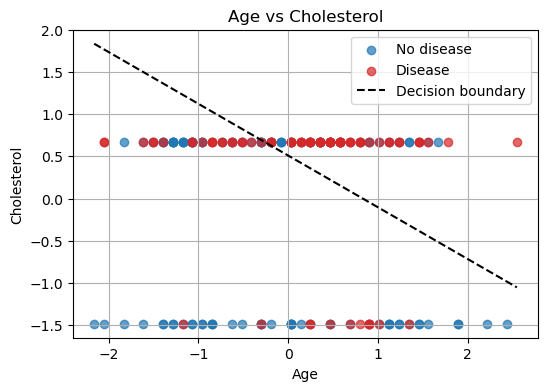

In [21]:
x_age_cholesterol = X_train[:, [0, 1]]
y_age_cholesterol = y_train
x_age_cholesterol_mean = x_age_cholesterol.mean(axis=0)
x_age_cholesterol_std = x_age_cholesterol.std(axis=0) + 1e-8
x_age_cholesterol = (x_age_cholesterol - x_age_cholesterol_mean) / x_age_cholesterol_std
w_age_cholesterol = np.zeros(2)
b_age_cholesterol = 0.0
w_age_trained, b_age_trained, J_hist_age = gradient_descent(x_age_cholesterol, y_age_cholesterol, w_age_cholesterol, b_age_cholesterol, 0.01, 2000)
plot_boundary_and_scatter(x_age_cholesterol, y_age_cholesterol, w_age_trained, b_age_trained, "Age vs Cholesterol", ["Age", "Cholesterol"])

### BP-Max HR

Iteration    0: J(w,b) = 0.6929
Iteration   50: J(w,b) = 0.6838
Iteration  100: J(w,b) = 0.6770
Iteration  150: J(w,b) = 0.6718
Iteration  200: J(w,b) = 0.6680
Iteration  250: J(w,b) = 0.6650
Iteration  300: J(w,b) = 0.6628
Iteration  350: J(w,b) = 0.6611
Iteration  400: J(w,b) = 0.6598
Iteration  450: J(w,b) = 0.6588
Iteration  500: J(w,b) = 0.6580
Iteration  550: J(w,b) = 0.6574
Iteration  600: J(w,b) = 0.6569
Iteration  650: J(w,b) = 0.6565
Iteration  700: J(w,b) = 0.6562
Iteration  750: J(w,b) = 0.6560
Iteration  800: J(w,b) = 0.6558
Iteration  850: J(w,b) = 0.6557
Iteration  900: J(w,b) = 0.6556
Iteration  950: J(w,b) = 0.6555
Iteration 1000: J(w,b) = 0.6554
Iteration 1050: J(w,b) = 0.6554
Iteration 1100: J(w,b) = 0.6553
Iteration 1150: J(w,b) = 0.6553
Iteration 1200: J(w,b) = 0.6553
Iteration 1250: J(w,b) = 0.6553
Iteration 1300: J(w,b) = 0.6552
Iteration 1350: J(w,b) = 0.6552
Iteration 1400: J(w,b) = 0.6552
Iteration 1450: J(w,b) = 0.6552
Iteration 1500: J(w,b) = 0.6552
Iteratio

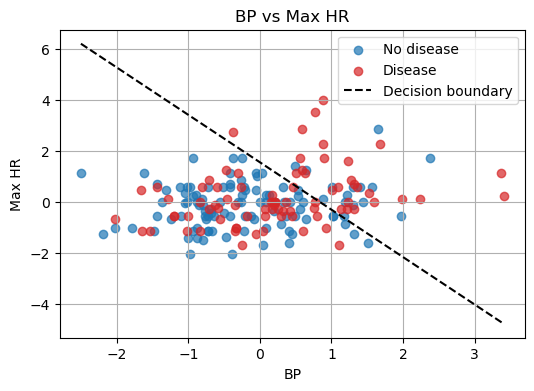

In [22]:
x_bp_maxHr = X_train[:, [2, 3]]
y_bp_maxHr = y_train
x_bp_maxHr_mean = x_bp_maxHr.mean(axis=0)
x_bp_maxHr_std = x_bp_maxHr.std(axis=0) + 1e-8
x_bp_maxHr = (x_bp_maxHr - x_bp_maxHr_mean) / x_bp_maxHr_std
w_bp_maxHr = np.zeros(2)
b_bp_maxHr = 0.0
w_bp_maxHr, b_bp_maxHr, J_hist_bp = gradient_descent(x_bp_maxHr, y_bp_maxHr, w_bp_maxHr, b_bp_maxHr, 0.01, 2000)
plot_boundary_and_scatter(x_bp_maxHr, y_bp_maxHr, w_bp_maxHr, b_bp_maxHr, "BP vs Max HR", ["BP", "Max HR"])

### ST Depression-Vessels

Iteration    0: J(w,b) = 0.6924
Iteration   50: J(w,b) = 0.6597
Iteration  100: J(w,b) = 0.6362
Iteration  150: J(w,b) = 0.6193
Iteration  200: J(w,b) = 0.6069
Iteration  250: J(w,b) = 0.5976
Iteration  300: J(w,b) = 0.5907
Iteration  350: J(w,b) = 0.5855
Iteration  400: J(w,b) = 0.5815
Iteration  450: J(w,b) = 0.5784
Iteration  500: J(w,b) = 0.5760
Iteration  550: J(w,b) = 0.5741
Iteration  600: J(w,b) = 0.5726
Iteration  650: J(w,b) = 0.5715
Iteration  700: J(w,b) = 0.5705
Iteration  750: J(w,b) = 0.5698
Iteration  800: J(w,b) = 0.5692
Iteration  850: J(w,b) = 0.5687
Iteration  900: J(w,b) = 0.5683
Iteration  950: J(w,b) = 0.5680
Iteration 1000: J(w,b) = 0.5678
Iteration 1050: J(w,b) = 0.5676
Iteration 1100: J(w,b) = 0.5674
Iteration 1150: J(w,b) = 0.5673
Iteration 1200: J(w,b) = 0.5672
Iteration 1250: J(w,b) = 0.5671
Iteration 1300: J(w,b) = 0.5670
Iteration 1350: J(w,b) = 0.5670
Iteration 1400: J(w,b) = 0.5669
Iteration 1450: J(w,b) = 0.5669
Iteration 1500: J(w,b) = 0.5668
Iteratio

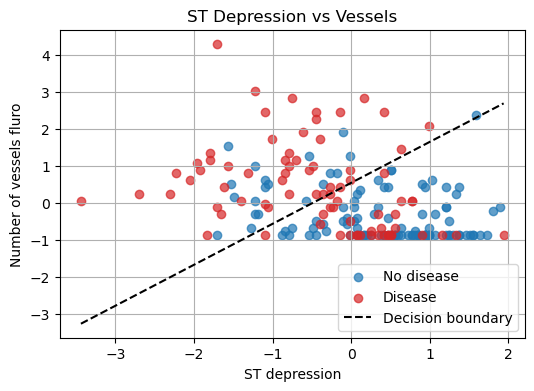

In [23]:
x_st_vessels = X_train[:, [4, 5]]
y_st_vessels = y_train
x_st_vessels_mean = x_st_vessels.mean(axis=0)
x_st_vessels_std = x_st_vessels.std(axis=0) + 1e-8
x_st_vessels = (x_st_vessels - x_st_vessels_mean) / x_st_vessels_std
w_st_vessels_init = np.zeros(2)
b_st_vessels_init = 0.0
w_st_vessels, b_st_vessels, J_hist_st = gradient_descent(x_st_vessels, y_st_vessels, w_st_vessels_init, b_st_vessels_init, 0.01, 2000)
plot_boundary_and_scatter(x_st_vessels, y_st_vessels, w_st_vessels, b_st_vessels, "ST Depression vs Vessels", ["ST depression", "Number of vessels fluro"])

## Discuss About separability/nonlinearity.

The key difference between separability and nonlinearity lies in their focus: separability examines whether classes can be divided by a straight line (linear boundary), revealing how easily the model can distinguish between healthy and diseased patients using specific feature pairs, while nonlinearity addresses the inadequacy of straight lines to capture complex relationships, indicating when risk factors interact in curved or threshold-based patterns that require more sophisticated modeling beyond simple linear combinations to accurately represent the underlying medical reality of heart disease.

## Step 4

### Regularized Cost Function

In [24]:
def compute_cost_log_reg_reg(w, b, X, y, lam):
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)
    eps = 1e-8
    f_clipped = np.clip(f, eps, 1 - eps)
    ce = - (1 / m) * np.sum(
        y * np.log(f_clipped) + (1 - y) * np.log(1 - f_clipped)
    )
    reg = (lam / (2*m)) * np.sum(w ** 2)
    return ce + reg

### Regularized Gradient Function

In [25]:
def compute_gradient_log_reg_reg(w, b, X, y, lam):
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)
    error = f - y
    dj_dw = (1 / m) * (X.T @ error) + (lam / m) * w
    dj_db = (1 / m) * np.sum(error)
    return dj_dw, dj_db

### Regularized Gradient Descent

In [26]:
def gradient_descent_log_reg_reg(X, y, w_init, b_init, alpha, lam, num_iters):
    w = w_init.copy()
    b = b_init
    J_history = []
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient_log_reg_reg(w, b, X, y, lam)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        J_history.append(compute_cost_log_reg_reg(w, b, X, y, lam))
    return w, b, J_history

### Tune Lambda

Parameter λ (lambda)
Controls regularization strength:

λ = 0: No regularization (overfitting risk)

Small λ (0.001-0.01): Mild regularization

Moderate λ (0.1): Usually optimal balance

Large λ (1): Strong regularization (underfitting risk)

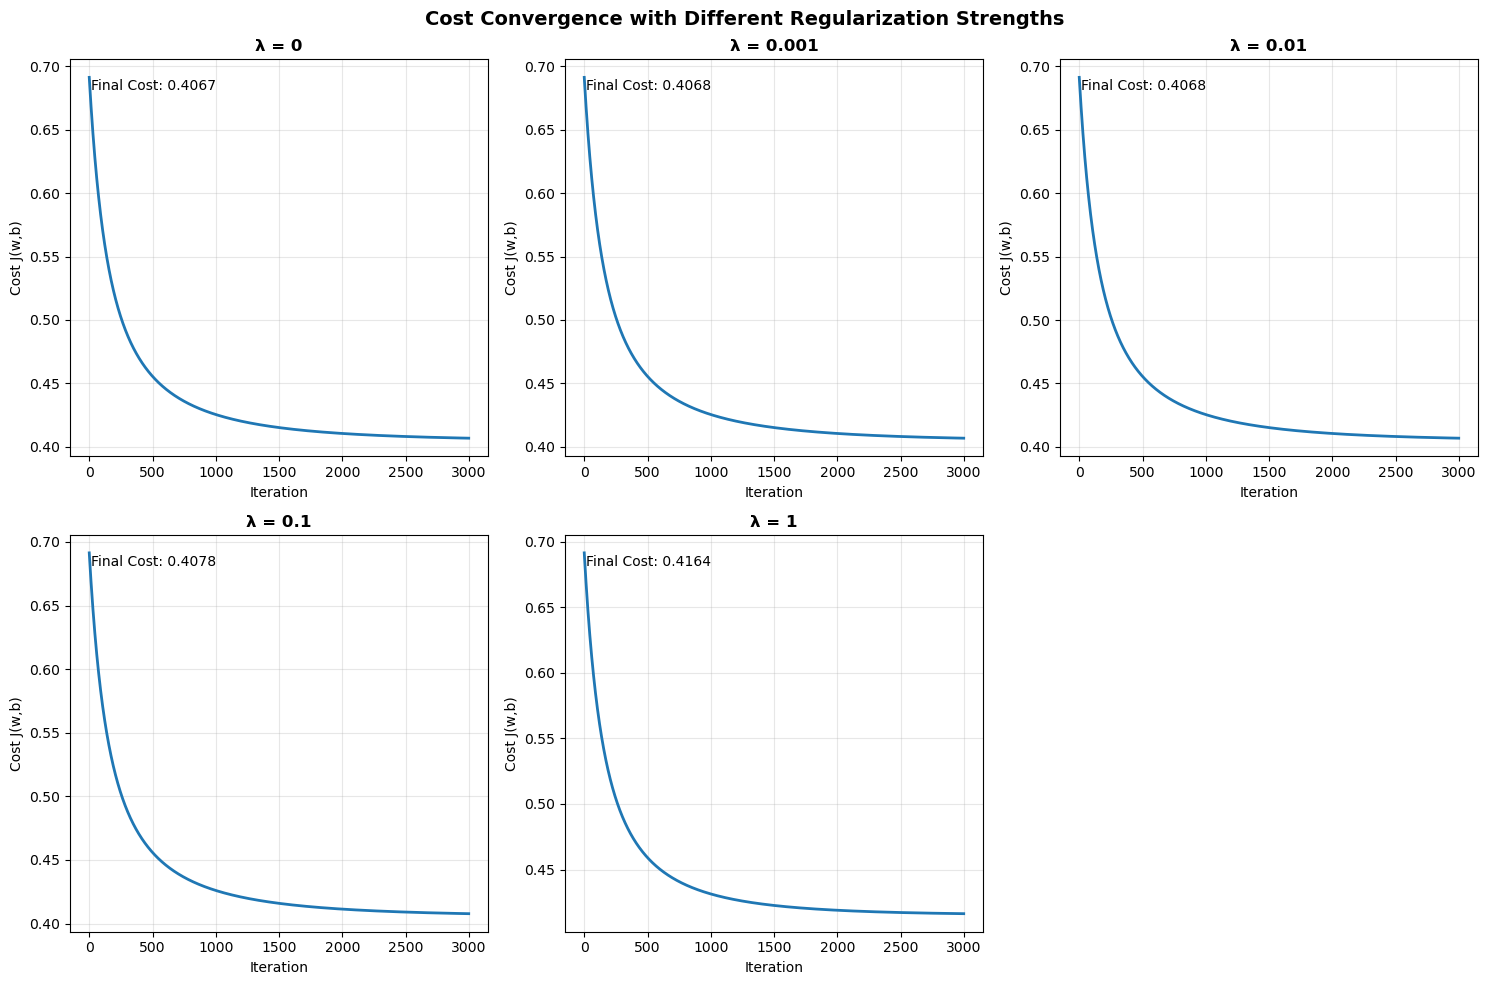

Iteration    0: J(w,b) = 0.6929
Iteration   50: J(w,b) = 0.6838
Iteration  100: J(w,b) = 0.6770
Iteration  150: J(w,b) = 0.6718
Iteration  200: J(w,b) = 0.6680
Iteration  250: J(w,b) = 0.6650
Iteration  300: J(w,b) = 0.6628
Iteration  350: J(w,b) = 0.6611
Iteration  400: J(w,b) = 0.6598
Iteration  450: J(w,b) = 0.6588
Iteration  500: J(w,b) = 0.6580
Iteration  550: J(w,b) = 0.6574
Iteration  600: J(w,b) = 0.6569
Iteration  650: J(w,b) = 0.6565
Iteration  700: J(w,b) = 0.6562
Iteration  750: J(w,b) = 0.6560
Iteration  800: J(w,b) = 0.6558
Iteration  850: J(w,b) = 0.6557
Iteration  900: J(w,b) = 0.6556
Iteration  950: J(w,b) = 0.6555
Iteration 1000: J(w,b) = 0.6554
Iteration 1050: J(w,b) = 0.6554
Iteration 1100: J(w,b) = 0.6553
Iteration 1150: J(w,b) = 0.6553
Iteration 1200: J(w,b) = 0.6553
Iteration 1250: J(w,b) = 0.6553
Iteration 1300: J(w,b) = 0.6552
Iteration 1350: J(w,b) = 0.6552
Iteration 1400: J(w,b) = 0.6552
Iteration 1450: J(w,b) = 0.6552
Iteration 1500: J(w,b) = 0.6552
Iteratio

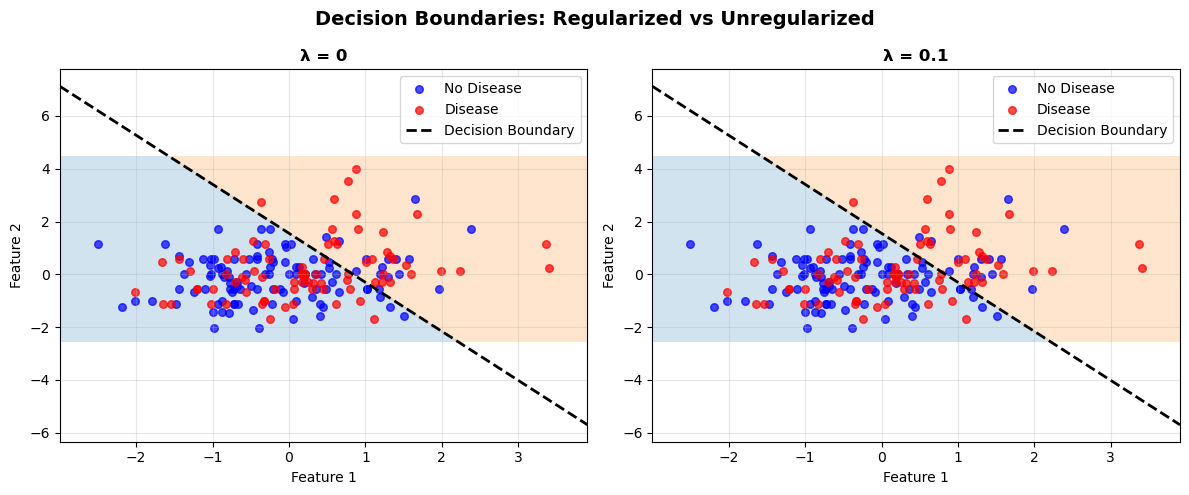

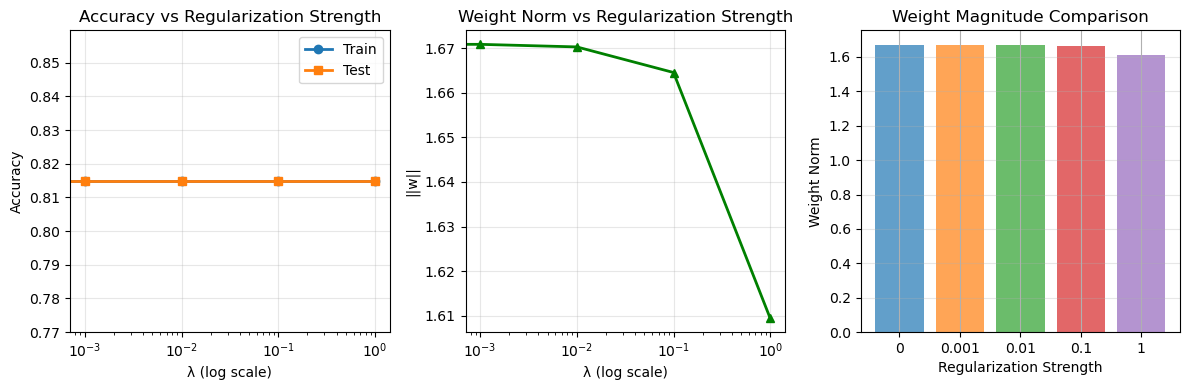

In [30]:
def plot_regularization_comparison():
    lambdas = [0, 0.001, 0.01, 0.1, 1]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, lam in enumerate(lambdas):
        w0 = np.zeros(X_train.shape[1])
        b0 = 0.0
        w_reg, b_reg, J_hist = gradient_descent_log_reg_reg(
            X_train, y_train, w0, b0, 0.01, lam, 3000
        )
        
        ax = axes[idx]
        ax.plot(J_hist, linewidth=2)
        ax.set_title(f'λ = {lam}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Cost J(w,b)')
        ax.grid(True, alpha=0.3)
        ax.text(0.05, 0.95, f'Final Cost: {J_hist[-1]:.4f}', 
                transform=ax.transAxes, verticalalignment='top')
    
    axes[-1].axis('off')
    plt.suptitle('Cost Convergence with Different Regularization Strengths', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_regularization_comparison()

def compare_decision_boundaries():
    lambdas = [0, 0.1]
    feature_idx1, feature_idx2 = 2, 3
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    X_pair = X_train[:, [feature_idx1, feature_idx2]]
    
    for idx, lam in enumerate(lambdas):
        w0_pair = np.zeros(2)
        b0_pair = 0.0
        
        if lam == 0:
            w_reg, b_reg, _ = gradient_descent(X_pair, y_train, w0_pair, b0_pair, 0.01, 2000)
        else:
            w_reg, b_reg, _ = gradient_descent_log_reg_reg(X_pair, y_train, w0_pair, b0_pair, 0.01, lam, 2000)
        
        ax = axes[idx]
        
        x_min, x_max = X_pair[:, 0].min() - 0.5, X_pair[:, 0].max() + 0.5
        y_min, y_max = X_pair[:, 1].min() - 0.5, X_pair[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                            np.linspace(y_min, y_max, 200))
        grid = np.c_[xx.ravel(), yy.ravel()]
        z = grid @ w_reg + b_reg
        probs = sigmoid(z).reshape(xx.shape)
        
        ax.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["tab:blue", "tab:orange"])
        ax.scatter(X_pair[y_train == 0, 0], X_pair[y_train == 0, 1], 
                  c="blue", label="No Disease", alpha=0.7, s=30)
        ax.scatter(X_pair[y_train == 1, 0], X_pair[y_train == 1, 1], 
                  c="red", label="Disease", alpha=0.7, s=30)
        
        decision_line_x = np.linspace(x_min, x_max, 100)
        if abs(w_reg[1]) > 1e-8:
            decision_line_y = -(w_reg[0] * decision_line_x + b_reg) / w_reg[1]
            ax.plot(decision_line_x, decision_line_y, 'k--', linewidth=2, label='Decision Boundary')
        
        ax.set_title(f'λ = {lam}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Decision Boundaries: Regularized vs Unregularized', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

compare_decision_boundaries()

lambdas = [0, 0.001, 0.01, 0.1, 1]
train_accs = []
test_accs = []
weight_norms = []

for lam in lambdas:
    w0 = np.zeros(X_train.shape[1])
    b0 = 0.0
    w_reg, b_reg, _ = gradient_descent_log_reg_reg(X_train, y_train, w0, b0, 0.01, lam, 2000)
    
    y_pred_train = predict(X_train, w_reg, b_reg)
    y_pred_test = predict(X_test, w_reg, b_reg)
    
    TP_train, TN_train, FP_train, FN_train = calculateParameters(y_train, y_pred_train)
    TP_test, TN_test, FP_test, FN_test = calculateParameters(y_test, y_pred_test)
    
    acc_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train)
    acc_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test)
    
    train_accs.append(acc_train)
    test_accs.append(acc_test)
    weight_norms.append(np.linalg.norm(w_reg))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(lambdas, train_accs, 'o-', label='Train', linewidth=2)
plt.plot(lambdas, test_accs, 's-', label='Test', linewidth=2)
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Regularization Strength')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(lambdas, weight_norms, '^-', color='green', linewidth=2)
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('||w||')
plt.title('Weight Norm vs Regularization Strength')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
for i, lam in enumerate(lambdas):
    plt.bar(i, weight_norms[i], alpha=0.7, label=f'λ={lam}')
plt.xticks(range(len(lambdas)), [str(lam) for lam in lambdas])
plt.xlabel('Regularization Strength')
plt.ylabel('Weight Norm')
plt.title('Weight Magnitude Comparison')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Regularized Decision Boundary Plot

In [31]:
def plot_decision_boundary_logreg(w, b, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    z = grid @ w + b
    probs = sigmoid(z).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["tab:blue", "tab:orange"])
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="y = 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="y = 1")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()

### Compare Unregularized vs Regularized

Iteration    0: J(w,b) = 0.6929
Iteration   50: J(w,b) = 0.6838
Iteration  100: J(w,b) = 0.6770
Iteration  150: J(w,b) = 0.6718
Iteration  200: J(w,b) = 0.6680
Iteration  250: J(w,b) = 0.6650
Iteration  300: J(w,b) = 0.6628
Iteration  350: J(w,b) = 0.6611
Iteration  400: J(w,b) = 0.6598
Iteration  450: J(w,b) = 0.6588
Iteration  500: J(w,b) = 0.6580
Iteration  550: J(w,b) = 0.6574
Iteration  600: J(w,b) = 0.6569
Iteration  650: J(w,b) = 0.6565
Iteration  700: J(w,b) = 0.6562
Iteration  750: J(w,b) = 0.6560
Iteration  800: J(w,b) = 0.6558
Iteration  850: J(w,b) = 0.6557
Iteration  900: J(w,b) = 0.6556
Iteration  950: J(w,b) = 0.6555
Iteration 1000: J(w,b) = 0.6554
Iteration 1050: J(w,b) = 0.6554
Iteration 1100: J(w,b) = 0.6553
Iteration 1150: J(w,b) = 0.6553
Iteration 1200: J(w,b) = 0.6553
Iteration 1250: J(w,b) = 0.6553
Iteration 1300: J(w,b) = 0.6552
Iteration 1350: J(w,b) = 0.6552
Iteration 1400: J(w,b) = 0.6552
Iteration 1450: J(w,b) = 0.6552
Iteration 1500: J(w,b) = 0.6552
Iteratio

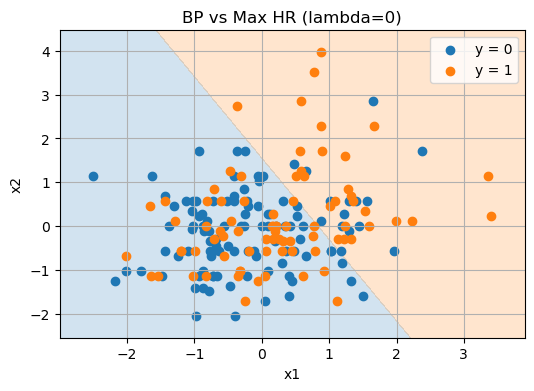

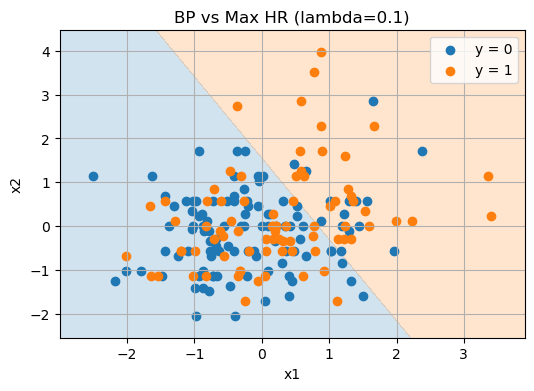

In [64]:
X_pair = X_train[:, [2, 3]]
y_pair = y_train
w0 = np.zeros(2)
b0 = 0.0
w_unreg, b_unreg, J_unreg = gradient_descent(X_pair, y_pair, w0, b0, 0.01, 2000)
lam = 0.1
w_reg, b_reg, J_reg = gradient_descent_log_reg_reg(X_pair, y_pair, w0, b0, 0.01, lam, 2000)
plot_decision_boundary_logreg(w_unreg, b_unreg, X_pair, y_pair, "BP vs Max HR (lambda=0)")
plot_decision_boundary_logreg(w_reg, b_reg, X_pair, y_pair, f"BP vs Max HR (lambda={lam})")